In [30]:
# Import Libraries and Dependencies

import numpy as np
import matplotlib.pyplot as plt
from random import uniform
from time import perf_counter
import scipy as sp
from scipy import linalg
from scipy.sparse import random
import numpy.linalg as LA

import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need

#seed
np.random.seed(78456)

# Init

In [3]:
# needed beforehand
M = 15
D = 10
N = 4

A = np.ones((N,D))

fx = lambda x: np.linalg.norm(x)
gradf = lambda x: 2*x
hx = []
gradh = []
for i in range(M):
    hi = lambda x: np.linalg.norm(-x)
    gradhi = lambda x: -2*x
    hx.append(hi)
    gradh.append(gradhi)
    
x = np.ones(D)
y = np.ones(M)
u = np.ones(N)
b = np.ones(N)
print(x.shape)
print(y.shape)
print(u.shape)
print(np.concatenate((x,y,u)).shape)

(10,)
(15,)
(4,)
(29,)


In [129]:

p_temp = np.random.rand(5,5)
print(np.dot(p_temp.transpose(), p_temp))
print(np.linalg.eigvals(np.maximum(p_temp, p_temp.transpose())))

[[2.19563146 1.54572424 1.13891863 2.45774534 1.5217481 ]
 [1.54572424 1.25884063 0.94494893 1.82089766 1.06761785]
 [1.13891863 0.94494893 0.77055131 1.29503261 0.96927014]
 [2.45774534 1.82089766 1.29503261 3.01765233 1.66576049]
 [1.5217481  1.06761785 0.96927014 1.66576049 1.72866674]]
[8.01154095e+00 6.47470034e-01 6.52906467e-05 1.02512199e-01
 2.09754007e-01]


# Prototype Functions

In [132]:
def randQCQP(N_, M_, convex_, equality_):
    p = []
    q = []
    r = []
    x_rand = np.random.rand(N_)
    if convex_:
        p_temp = np.random.rand(N_, N_)
        p.append(np.dot(p_temp, p_temp.transpose()))
    else:
        p_temp = np.random.rand(N_, N_)
        p.append(np.maximum(p_temp, p_temp.transpose()))
    q.append(np.random.rand(N_))
    r.append(-1)
    for i in range(1,M_):
        if convex_:
            p_temp = np.random.rand(N_, N_)
            p_temp = np.dot(p_temp, p_temp.transpose())
        else:
            p_temp = np.random.rand(N_, N_)
            p_temp = np.maximum(p_temp, p_temp.transpose())
        
        p.append(p_temp)
        q_temp = np.random.rand(N_)
        q.append(q_temp)
        r.append(-0.5*x_rand.T@p_temp@x_rand - q_temp@x_rand)
    if equality_:
        A = np.random.rand(M_,N_)
        b = A@x_rand
        return p, q, r, A, b
    else:
        return p, q, r, None, None
    

def toQCQP(P_, q_, r_):
    fx = lambda x: 0.5*x.T@P_[0]@x + q_[0]@x
    gradf = lambda x: x.T@P_[0] + q_[0]
    hxs = []
    gradhs = []
    for i in range(1,len(P_)):
        hx = lambda x: 0.5*x.T@P_[i]@x + q_[i]@x+r_[i]
        gradh = lambda x: x.T@P_[i] + q_[i]
        hxs.append(hx)
        gradhs.append(gradh)
    return fx, hxs, gradf, gradhs

def minus(x1_, x2_, y1_=None, y2_=None, u1_=None, u2_=None):
    if u1_ is None and u2_ is None:
        if y1_ is None and y2_ is None:
            return x1_ - x2_, None, None
        else:
            return x1_ - x2_, y1_ - y2_, None
    else:
        return x1_ - x2_, y1_ - y2_, u1_ - u2_
    

def create_F(gradf_, hx_, gradh_, A_=None, b_=None):
    if A_ is None:
        def Fx(x_,y_):
            if gradh_ is None or hx_ is None:
                return gradf(x_), None, None
            else:
                vec_prod_ = np.zeros(len(x_))
                fy = np.zeros(len(y_))
                for i in range(len(y_)):
                    vec_prod_ += y_[i] * gradh[i](x_)
                    fy[i] = -hx[i](x_)
                fx = gradf(x_)+ sum(vec_prod_)
                return fx, fy, None
    else:
        def Fx(x_,y_,u_):
            if gradh_ is None or hx_ is None:
                fx = gradf(x_)
                fu = b-A@x_
                return fx, None, fu
            else:
                vec_prod_ = np.zeros(len(x_))
                fy = np.zeros(len(y_))
                for i in range(len(y_)):
                    vec_prod_ += y_[i] * gradh[i](x_)
                    fy[i] = -hx[i](x_)
                fx = gradf(x_)+ sum(vec_prod_)+ A.T@u_
                fu = b-A@x_
                return fx, fy, fu
    return Fx

def create_J(gradf_, hx_, gradh_, proj_, A_=None, b_=None):
    if A_ is None:
        Fx = create_F(gradf_, hx_, gradh_)
        def J(x,y):
            if hx_ is None or gradh_ is None:
                fx, _, _ = Fx(x,y)
                xp, yp, _ = minus(x, fx)
                xp, yp, _ = operator_P(proj_, xp)
                xp, yp, _ = minus(x, xp)
                return np.linalg.norm(xp)
            else:
                fx, fy, _ = Fx(x,y)
                print(fx, fy)
                xp, yp, _ = minus(x, fx, y, fy)
                xp, yp, _ = operator_P(proj_, xp, yp)
                xp, yp, _ = minus(x, xp, y, yp)
                return np.linalg.norm(xp) + np.linalg.norm(yp)
    else:
        Fx = create_F(gradf_, hx_, gradh_, A_, b_)
        def J(x,y,u):
            if hx_ is None or gradh_ is None:
                something
            else:
                fx, fy, fu = Fx(x,y,u)
                print(fx, fy, fu)
                xp, yp, up = minus(x, fx, y, fy, u, fu)
                xp, yp, up = operator_P(proj_, xp, yp, up)
                xp, yp, up = minus(x, xp, y, yp, u, up)
                return np.linalg.norm(xp) + np.linalg.norm(yp) + np.linalg.norm(up)
    return J
def operator_P(proj_, x_, y_=None, u_=None):
    if proj_ is None:
        if y_ is None:
            return x_, y_, u_
        else:
            return x_, np.maximum(y_,0), u_
    else:
        if y_ is None:
            return proj_(x_), y_, u_
        else:
            return proj_(x_), np.maximum(y_,0)


class co_problem:
    """
    Class definition of constrained optimization library
    """
    def __init__(self, fx_, hxs_=None, proj_=None, gradf_=None, gradhs_=None, A_=None, b_=None): #
        """
        Initialization of qcqp_problem class that containts:

        Parameters
        ----------
        A : ndarray/string
            the matrix A for the MG problem. If "None" gives a random 10x10 matrix
            default "None". Can load a type one of the following matrices using the string:
            - "rock_paper_scissor"      : payoff matrix for the game rock, paper, scissor
            - "marriage_problem_small"  : Hall's marriage problem as a 10x10 matrix
            - "normandy"                : Matrix from “Normandy: Game and Reality”[1]
            - "diag"                    : random diagonal game matrix
                           second dim will be considered to make nxn matrix
            - "triangular"              : random upper triangular matrix
            - "rand"                    : a random 10x10 matrix
            - "rand_sparse"             : a random 10x10 sparse matrix [2]
            Or supply own matrix A 
            
        Returns
        -------
        out : qcqp_problem object

        Notes
        -----

        References
        ----------

        Examples
        --------
        """
        ### Check "F" ###
        if isinstance(fx_, str):
            if fx_ is "name1":
                #stuff
                x = 0
        elif callable(fx_):
            self.fx = fx_                                   #var
            ### Check "H" ###
            if hxs_ is None:
                self.hx = None
                self.gradh = None
            elif isinstance(hxs_, list):
                for i in range(len(hxs_)):
                    if not callable(hxs_[i]):
                        raise ValueError('"hx"; Input of wrong format. Please refer to the documentation.') 
                self.hx = hxs_                               #var
                self.M = len(hxs_)                           #var
                ### Check "gradh" ###
                if gradhs_ is None:
                    self.gradh = []
                    for i in range(len(self.hx)):
                        gradhi = grad(self.hx[i])
                        self.gradh.append(gradhi)
                elif isinstance(gradhs_, list):
                    for i in range(len(gradhs_)):
                        if not callable(gradhs_[i]):
                            raise ValueError('"gradh"; Input of wrong format. Please refer to the documentation.') 
                    self.gradh = gradhs_                         #var
                else :
                    raise ValueError('"gradh"; Input of wrong format. Please refer to the documentation.')
            else :
                raise ValueError('"hx"; Input of wrong format. Please refer to the documentation.')
            ### Check "gradf" ###
            if gradf_ is None:
                self.gradf = grad(self.fx)
            elif callable(gradf_):
                self.gradf = gradf_                          #var
            else:
                raise ValueError('"gradf"; Input of wrong format. Please refer to the documentation.')
            ### Check "A" ###
            if A_ is None:
                self.A = None                            
            elif isinstance(A_, np.array):
                self.A = A_                                  #var
                if isinstance(b_, np.array):
                    self.b = b_                                  #var
                elif b_ is None:
                    raise ValueError('"b": Cannot input matrix A without vector b. Please refer to the documentation.')
                else:
                    raise ValueError('"b"; Input of wrong format. Please refer to the documentation.')
            else:
                raise ValueError('"A"; Input of wrong format. Please refer to the documentation.')
        else:
            raise ValueError('"fx"; Input of wrong format. Please refer to the documentation.') 
        if proj_ is None:
            self.proj = None
        elif callable(proj_):
            self.proj = proj_
        else:
            raise ValueError('"proj"; Input of wrong format. Please refer to the documentation.') 
            
        if self.A is None:
            self.F = create_F(self.gradh, self.hx, self.gradh)
            self.J = create_J(self.gradh, self.hx, self.gradh, self.proj)
        else:
            self.F = create_F(self.gradh, self.hx, self.gradh, self.A, self.b)
            self.J = create_J(self.gradh, self.hx, self.gradh, self.proj, self.A, self.b)
        
        
    
    
    
z = [x,y]
lists = []
lists.append(0)
lists.append(54)
prob = co_problem(fx)
prob.J(x,np.array(0))


0.0

In [136]:
randQCQP(2,3,True,True)

([array([[0.93485483, 0.91196591],
         [0.91196591, 1.47120202]]), array([[0.07737701, 0.21282905],
         [0.21282905, 0.63283604]]), array([[0.39112514, 0.4022725 ],
         [0.4022725 , 0.46998196]])],
 [array([0.29707034, 0.18007894]),
  array([0.81737589, 0.08790858]),
  array([0.98359361, 0.98003865])],
 [-1, -0.9609908914815968, -1.87168109911185],
 array([[0.07894704, 0.42071859],
        [0.02107505, 0.13304685],
        [0.57872254, 0.26122749]]),
 array([0.36338371, 0.11207601, 0.61217988]))

In [69]:
p = []
q = []
r = []
N = 20
for i in range(N):
    p.append(np.ones((N,N))*i)
    q.append(np.ones(N)*i*i)
    r.append(2*i)
print(p[0].shape)
fx, hx, gradf, gradh = toQCQP(p, q, r)
proj_v = lambda x: x
prob = co_problem(fx, hx, proj_v, gradf, gradh)
x = np.ones(N)
print(prob.gradf(x))

(20, 20)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
sp.linalg.orth(np.diag(np.array([2,3,4])))
print(np.maximum(x,0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
def tanh(x):                 # Define a function
    y = np.exp(-2.0 * x)
    #return (1.0 - y) / (1.0 + y)
    return x*x

grad_tanh = grad(tanh)       # Obtain its gradient function
print(grad_tanh(-1.0))              # Evaluate the gradient at x = 1.0
print((tanh(1.0001) - tanh(0.9999)) / 0.0002)  # Compare to finite differences

-2.0
1.9999999999992246


In [21]:
def test(x):
    if x is 0:
        return None, 5
    else:
        return x, 5
y, z = test(0)
print(y, z)

None 5


# Solving Algorithms

In [13]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list

In [14]:
def adaptive_graal_terminate(J, F, prox_g, x1, numb_iter=100, phi=1.5, tol=1e-6, output=False):
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    i = 1
    while i <= numb_iter and values[-1] > tol:
        i += 1
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = np.exp(np.log(n1) - np.log(n2))
        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2, 1e6)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)

        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)

    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, i

# Testing

In [15]:
ans1 = adaptive_graal(J, F, prox_g, q0, numb_iter=N, phi=1.5, output=False)

CPU time for aGRAAL: 149.85831509999997


In [16]:
print(ans1[0])

[7696.278569076685, 5459.190304754123, 7699.009196755063, 7698.828932184738, 7698.687833328726, 7698.531051082497, 7698.356834250327, 7698.163242292672, 7697.948118265772, 7697.709064591426, 7697.4434160912315, 7697.148209971206, 7696.820152404853, 7696.455581322018, 7696.050424961636, 7695.60015569512, 7695.099738564779, 7694.543573914645, 7693.9254334122, 7693.2383886716825, 7692.47473158933, 7691.625885385083, 7690.682305214536, 7689.633367064914, 7688.467243473886, 5139.0947647158355, 5121.822243697465, 5121.7678101835245, 5121.747028987035, 5121.733174960897, 5121.72393848175, 5121.717780521143, 5121.713675008772, 5121.710937863727, 5121.709113009131, 5121.707896378575, 5121.707085250984, 5121.706544472207, 5121.706183935, 5121.705943564875, 5121.705783310082, 5121.705676468215, 5121.705605236753, 5121.70555774676, 5121.7055260851375, 5121.705504976384, 5121.705490903157, 5121.705481520506, 5121.70547526509, 5121.705471094631, 5121.705468314214, 5121.705466460465, 5121.70546522457

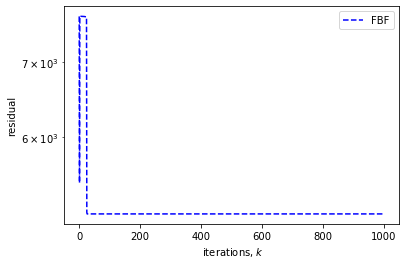

In [17]:
plt.plot(ans1[0], '--b', label = 'FBF')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

plt.legend()
#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()